In [210]:
# https://github.com/karpathy/micrograd
# https://www.youtube.com/watch?v=VMj-3S1tku0

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [211]:
# code for quick visualization of Values
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [212]:
# Derivatives overview
def f(x):
    return 3*x**2 - 4*x + 5
    # 3x^2 - 4x + 5

In [213]:
f(3.0)
# 3(3^2) - 4(3) + 5 = 27 - 12 + 5 = 20

20.0

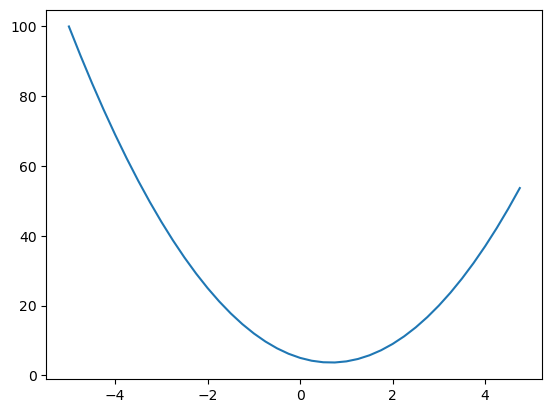

In [214]:
x_points = np.arange(-5, 5, 0.25) # builds array of points from -5 to 5 in .25 intervals
y_points = f(x_points)
plt.plot(x_points, y_points)

In [215]:
h = 0.0000001
x = 3.0
# if we nudge x by h, how does the function response. Curve slopes upward to f(x) would be greater
# neural networks are massive expressions with many variables

In [216]:
# create a Value class for gradient manipulation
class Value:
    def __init__(self, data, _children={}, _operation="", label=""):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _operation
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # create new value with self and other as children
        out = Value(self.data + other.data, (self, other), "+")
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
    def tanh(self):
        x = self.data
        # e^2x - 1 / e^2x + 1
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        return out
    
    def sigmoid(self):
        x = self.data
        t = (1 / (1 + math.exp(-x)))
        out = Value(t, (self, ), "sigmoid")
        return out
        

In [217]:
# example
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label ="e"
d = e + c; d.label="d"
f = Value(-2, label="f")
L = d * f; L.label="L"
L

Value(data=-8.0)

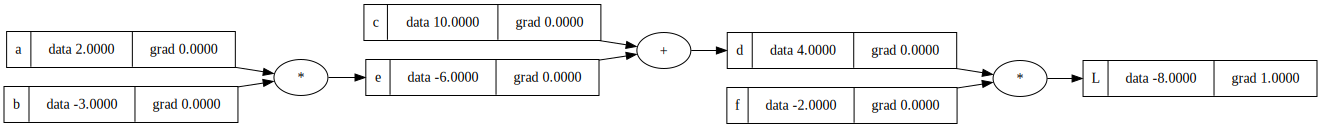

In [218]:
# multiple inputs going into an expression which produces L (loss)
# output of forward pass is -8

# backpropogation
# start at L, go backwards 
# calculate the gradient for each value by computing derivative of that node with respsect to L

# always start by setting L gradient to 1
L.grad = 1.0

draw_dot(L)

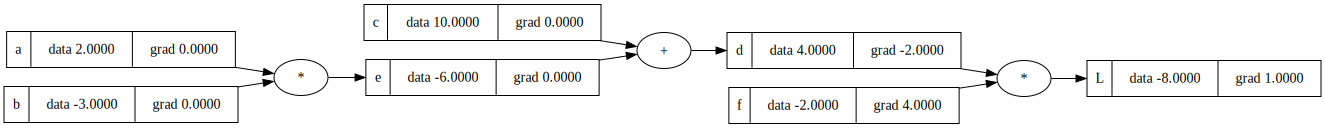

In [219]:
# derive dL/dd and dL/df
# L = d * f

# (f(x + h) - f(x)) / h as limit of h goes to 0

# how does L change with respect to changing d. f(x) = d*f, f(x + h) = (d + h)*f
# (((d + h) * f) - d*f) / h
# ((d * f) + (h * f) - (d * f)) / h
# (h * f) / h = f

# calculating dL/df = d, dL/dd = f
# case for multiplication

f.grad = d.data # 4
d.grad = f.data # -2

draw_dot(L)

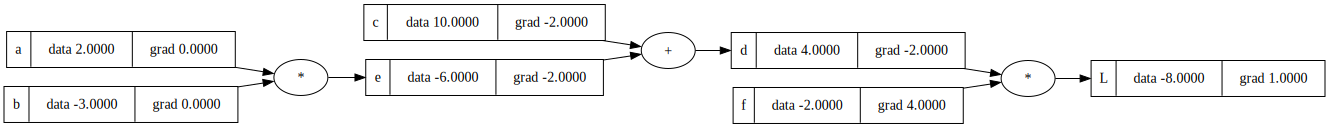

In [220]:
# derive dL/de and dL/dc
# how does changing e and c impact L

# first calculate dd/de and dd/dc or how does changing e and c impact d f(x) = e + c
# d = e + c
# f(x + h) - f(x) / h
# ((e + h) + c - (e + c)) / h
# (e + h + c - e - c) / h
# (h/h) = 1

# to get dL/de and dL/dc we need to use the calculus chain rule
# dL/de = dL/dd * dd/de
# since dd/de is 1, dL/de = dL/dd
# plus nodes just route gradients to children nodes since they are always 1

c.grad = d.grad
e.grad = d.grad

draw_dot(L)

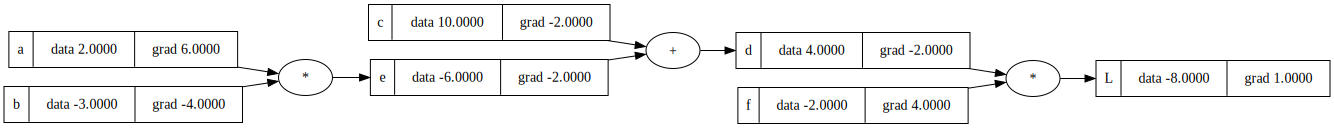

In [221]:
# want dL/da and dL/db

# Calculate de/da and de/db. Use chain rule to find dL/da and dL/db
# from example above de/db = 2 (or value of a) and de/da = -3 (or value of b)
# chain rule
# dL/db = de/db * dL/de
# -2 * 2 = -4 = dL/db
# -2 * -3 = 6 = dL/da

a.grad = b.data * e.grad
b.grad = a.data * e.grad

draw_dot(L)

In [222]:
# nudge all independent values in direction of gradient by a step size
# expect less L or closer to 0 L
# step size 0.01

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

L.data

# L is greater (closer to 0) than -8

-7.286496

In [223]:
# backpropogation through a neuron
# we take some input x's, synapses with weights (w)
# w*x

# cell body has bias that makes neuron more or less trigger happy
# summation(wi * wx) + b (bias)

# send it through a squashing activation function which determines whether the neuron should be activated or not
# sigmoid or tanh

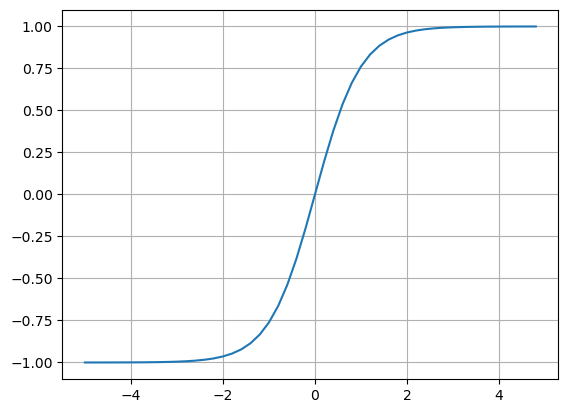

In [224]:
# tanh
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

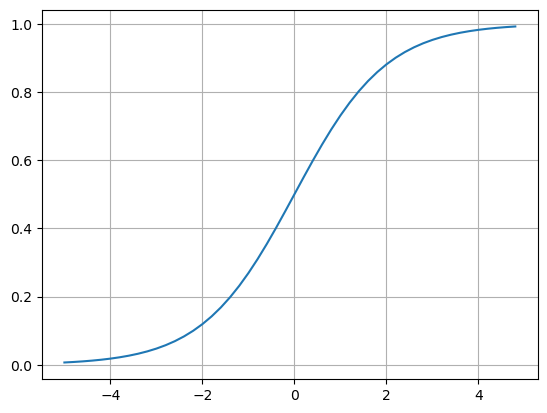

In [225]:
# sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
ys = np.arange(-5, 5, 0.2)

plt.plot(np.arange(-5, 5, 0.2), [sigmoid(y) for y in np.arange(-5, 5, 0.2)]); plt.grid();

Value(data=0.6899744811276125)
Value(data=0.6640367702678489)


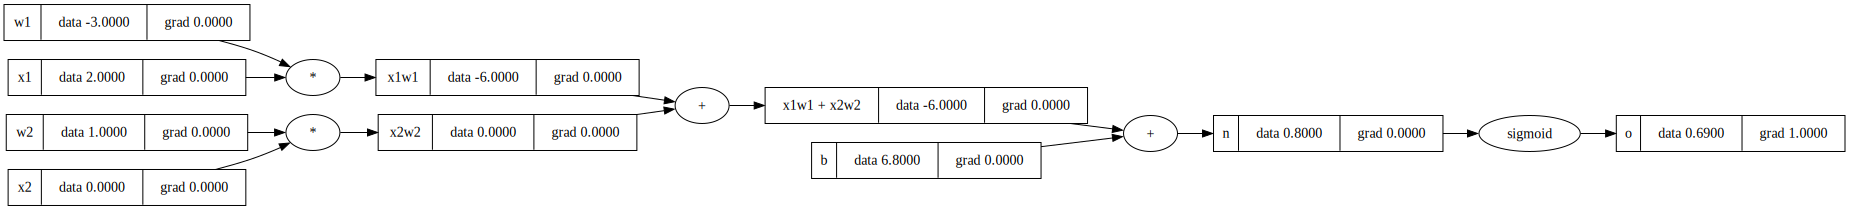

In [226]:
# example with 2 inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1 and w2. values randomly selected to start
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron. randomly selected for example
b = Value(6.8, label="b")

# (x1w1 + x2w2) + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

# output with activiation function
o_sigmoid = n.sigmoid();
o_tanh = n.tanh(); 

print(o_sigmoid)
print(o_tanh)

# use sigmoid for this example
o = n.sigmoid(); o.label = "o"
o.grad = 1.0

draw_dot(o)


In [227]:
# start backpropogation

# find do/dn 
# f(x) = 1 / 1 + e^-x

# f(x + h) - f(x) / h

# ((1 / 1 + e^-n+h) - (1 / 1 + e^-n)) / h

# https://hausetutorials.netlify.app/posts/2019-12-01-neural-networks-deriving-the-sigmoid-derivative/#:~:text=The%20derivative%20of%20the%20sigmoid%20function%20%CF%83(x)%20is%20the,1%E2%88%92%CF%83(x).
# (1 / 1 + e^-x)* (1 - (1 / 1 + e^-x))

# sigmoid(x) * (1 - sigmoid(x))

n.grad = (sigmoid(o.data) * (1 - sigmoid(o.data)))
n.grad


0.22245686352248503

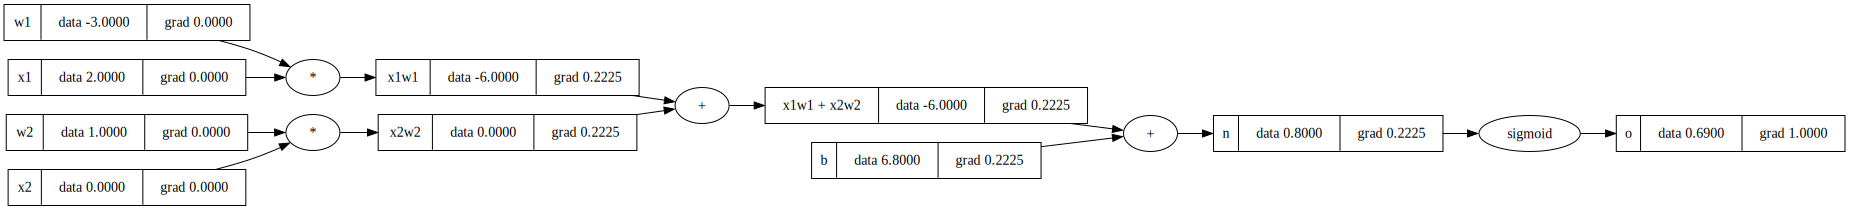

In [228]:
# + functions just take parent nodes
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

draw_dot(o)

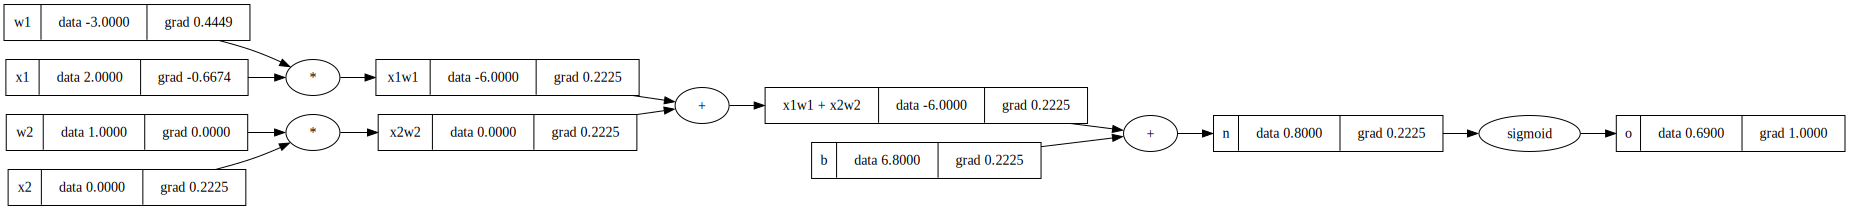

In [229]:
# use chain rule
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

draw_dot(o)

In [230]:
# update Value to calculate back propogation automatically
class Value:
    def __init__(self, data, _children={}, _operation="", label=""):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _operation
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # create new value with self and other as children
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        # e^2x - 1 / e^2x + 1
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.data
        t = (1 / (1 + math.exp(-x)))
        out = Value(t, (self, ), "sigmoid")
        
        def _backward():
            #(sigmoid(o.data) * (1 - sigmoid(o.data)))
            self.grad += (t * (1 - t)) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

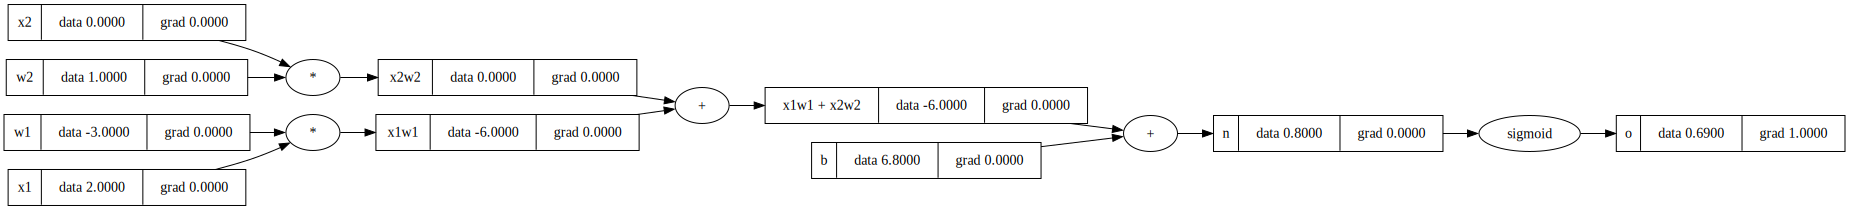

In [231]:
# redefine everything

# example with 2 inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1 and w2. values randomly selected to start
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron. randomly selected for example
b = Value(6.8, label="b")

# (x1w1 + x2w2) + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.sigmoid(); o.label = "o"
o.grad = 1.0

draw_dot(o)

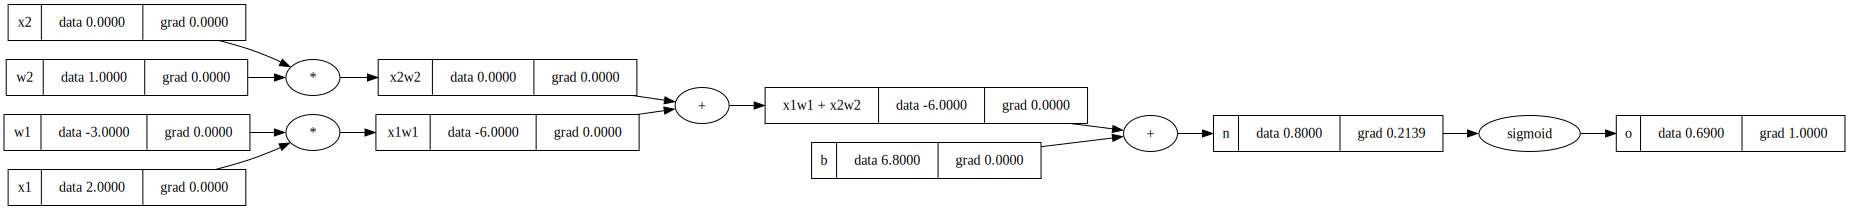

In [232]:
o._backward()
draw_dot(o)

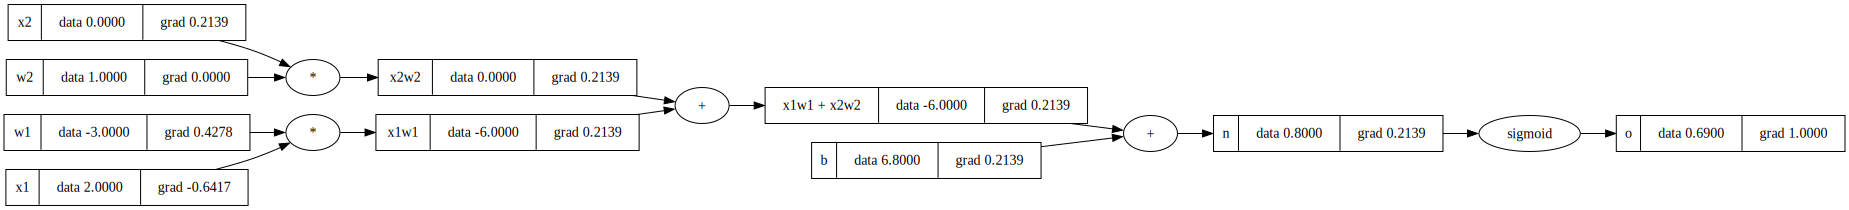

In [233]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

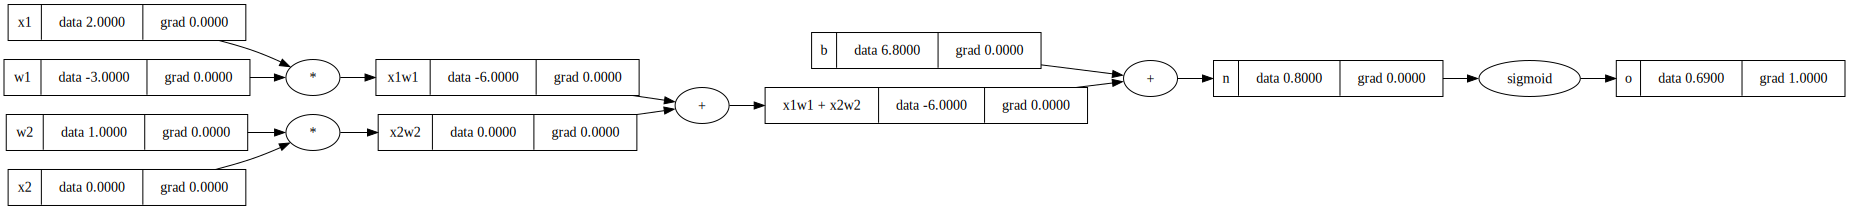

In [234]:
# redefine
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1 and w2. values randomly selected to start
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron. randomly selected for example
b = Value(6.8, label="b")

# (x1w1 + x2w2) + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.sigmoid(); o.label = "o"
o.grad = 1.0
draw_dot(o)

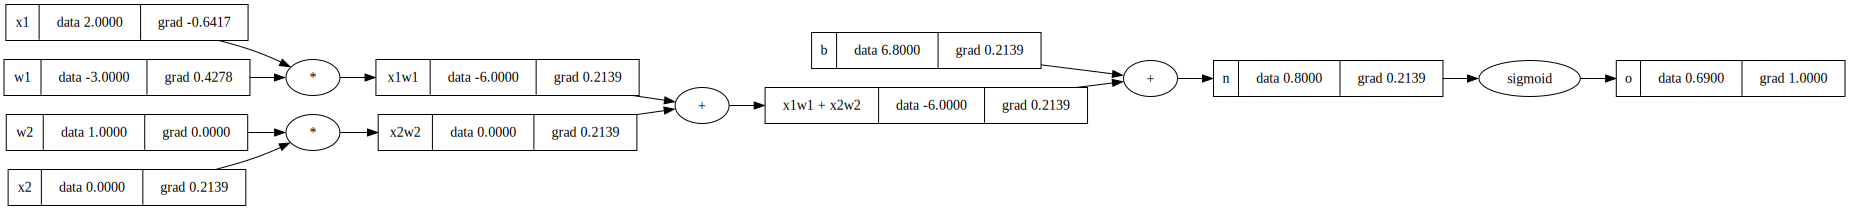

In [235]:
o.backward()
draw_dot(o)

In [236]:
# Backpropogation with PyTorch

import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2 * w2 + b
o = torch.sigmoid(n)

print(o.data.item())

o.backward()

print("----")
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

0.7071067435836176
----
x1 -0.621320390286569
w1 0.41421359352437936
x2 0.20710679676218968
w2 0.0


In [237]:
# example
import random
# numIn = number of parameters and weights per Neuron
class Neuron:
    def __init__(self, numIn):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(numIn)]
        self.bias = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        start = self.bias
        for wi, xi in zip(self.weights, x):
            start += (wi * xi)
        
        activation = start
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]

# list of neurons
# numIn = number of parameters and weights per Neuron
# numOut = number of neurons 
class Layer:
    def __init__(self, numIn, numOut):
        self.neurons = [Neuron(numIn) for _ in range(numOut)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# multi layer perceptron
# numIn = number of parameters and weights per Neuron
# numOut = array of size (number of neurons) per each layer
class MLP:
    def __init__(self, numIn, numOut):
        size = [numIn] + numOut
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(numOut))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

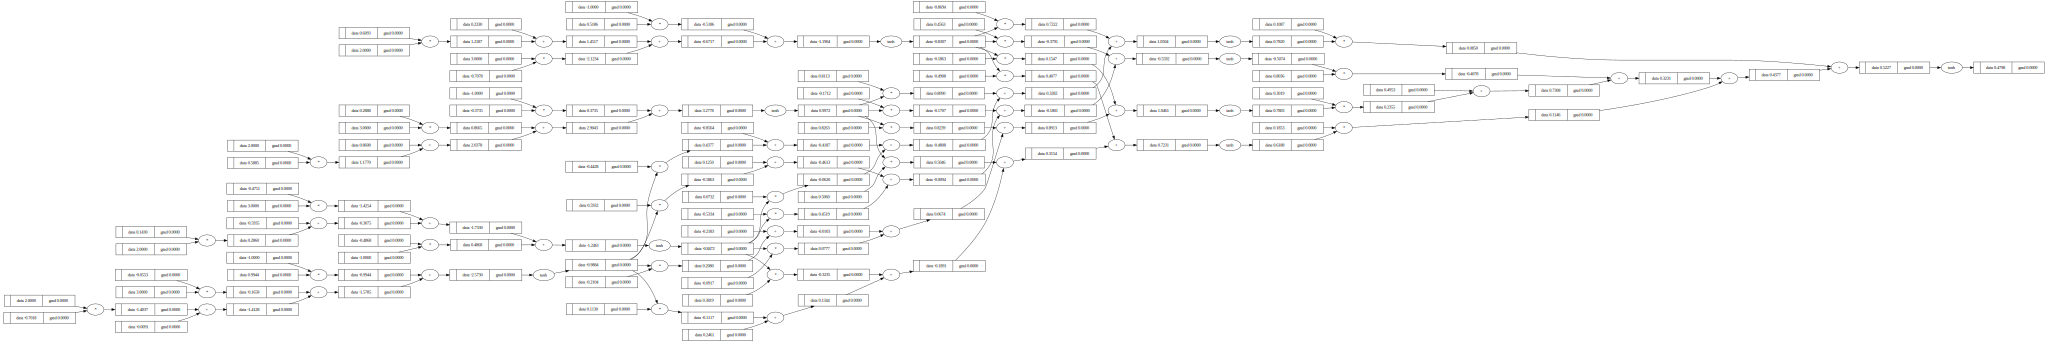

In [238]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [239]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.47977891632939274),
 Value(data=0.4633778826352159),
 Value(data=0.8168415946706152),
 Value(data=0.4435364169229492)]

In [240]:
def calculate_loss(ys, ypred):
    loss = 0
    for ygt, yout in zip(ys, ypred):
        loss += (yout - ygt)**2
    return loss
        
calculate_loss(ys, ypred)

Value(data=6.0226699026975625)

In [241]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = calculate_loss(ys, ypred)
    
    # backward pass
    # zero out gradients 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update values
    for p in n.parameters():
        # 0.05 step size
        p.data += -0.05 * p.grad
    print(k, loss.data)


0 6.0226699026975625
1 4.452116573725087
2 3.1739459287557237
3 1.9269104396570267
4 1.0411327574680633
5 0.621932078195609
6 0.42188652373201163
7 0.3119479455244379
8 0.244180978670422
9 0.19885207093381999
10 0.16668301598251636
11 0.1428166259926529
12 0.12449000605252894
13 0.11002618469146816
14 0.09835321721957753
15 0.0887563958777161
16 0.0807422456731154
17 0.07395986475483947
18 0.06815338469010482
19 0.06313214199576656
